Please refer to files Verlet_s_orbitals and p_orbitals_1 for detailed explanation of Verlet method. 

Now that we have the Verlet integrator function, we can use it in the shooting/bisection method. 
  
Flowchart for the shooting/bisection method:
1. Set an initial guess for the eigenvalue E called E1
2. Set a value called called E2 (for Bisection purposes)
3. Set a dE variable to modify E, where E2 = E1 + dE
4. Calculate f with the initial E1 guess
5. Define delta_0 as the difference between f and required condition at the last index
6. Calculate f again but with E2 guess
7. Define delta_2 as the difference between this f and required condition at the last index
8. If delta_2 is within the tolerance E2 is the answer; break
9. If delta_0 and delta_2 have different signs, bisect
10. E = (E1 + E2)/2 
11. Run Verlet to calculate f again
12. Repeat from step 6
13. If delta_0 and delta_2 have the same sign, then assign E1 = E2 and increment E2 by dE
14. Can check for edge cases along the way

Before, we worked on the Schrodinger equation for hydrogen:  
  
\begin{equation}
\frac{1}{r}\frac{d^2}{dr^2}(r\psi) = \frac{2m}{\hbar^2}(-E + V(r))\psi \\
\end{equation}

  
where V(r) = $- \frac{e^2}{r}$  
  
Now for excitons, the proposed Puls potential is:   
\begin{equation}
V(r) = \frac{-e^2}{\epsilon_0r_h}[1 - 2e^\frac{-2r_h}{a_e}(1+\frac{r_h}{a_e})] \\
\end{equation}
  
After the following assumptions and substitutions:  
  
\begin{equation}
\rho_h = \frac{r_h}{a_A}
\end{equation}

\begin{equation}
a_A = \frac{\hbar^2}{m_h e^2}
\end{equation}

\begin{equation}
a_D = \frac{\hbar^2}{m_e e^2}
\end{equation}

\begin{equation}
a_e = K a_D
\end{equation}

\begin{equation}
Ry_h = \frac{m_h e^4}{2\hbar^2}  
\end{equation}

\begin{equation}
Ry_e = \frac{m_e e^4}{2\hbar^2}  
\end{equation}

\begin{equation}
\epsilon_0 = 1
\end{equation}
    
  
The Puls Potential becomes (in Rydberg units):  
\begin{equation}
V(\rho_h) = \frac{-2}{\rho_h}[1 - 2e^{-2\rho_h a_A/a_e}(1+\rho_h a_A/a_e)] \\
\end{equation}
  
\begin{equation}
V(\rho_h) = \frac{-2}{\rho_h}[1 - 2e^{-2\rho_h m_e/(Km_h)}(1+\rho_h m_e/(Km_h))] \\
\end{equation}
    
where:  
  
$m_e$ = 0.28  
$m_h$ = 0.59  
K = 1.24 for the best agreement in Matt Frick's data
  
  
Finally to convert the energies (in acceptor Rydbergs just after calculations) to eV:
  
\begin{equation}
Ry_h = \frac{m_h}{m_e}\frac{m_e}{\epsilon^2}Ry = \frac{0.59}{8.5^2}(13.6~eV) = 0.111~eV
\end{equation}
  
where  
\begin{equation}
\frac{m_e}{\epsilon^2} 
\end{equation}  
  
is the convert $Ry_e$ to effective Rydbergs.  
  
Note that the x axis for the following graphs are in hole bohr radii. 

!!!!!! Please do not run the code section immediately below. It will take a long time to run. Skip to later sections to run if you need to. 

In [28]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
# Alias scipy as sp
import scipy as sp
# scipy.optimize for the curve_fit function
import scipy.optimize
import math

# define rho
totrho = 2000
rho_min = 0
rho_max = 100
rho = np.linspace(rho_min, rho_max, totrho)

def PulsV(r, K):
    mh = 0.59
    me = 0.28
    return -2/r*(1-2*np.exp(-2*r*me/(K*mh))*(1+r*me/(K*mh)))

def Verlet(epsilon, l, K):
    # defining rho range
    totrho = 2000
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    drho = (rho_max)/(totrho)
    
    # initialize a zero list of the wavefunction of length rho
    length = totrho
    f = [0]*length
   
    # set the end values of f; mind the indexing 
    f[length - 1] = 0
    f[length - 2] = 10**-10
    
    for i in range(length-2, 0, -1):
        f[i-1] = 2*f[i] - f[i+1] + drho**2*(-epsilon + PulsV(rho[i], K) + l*(l+1)/(rho[i]**2))*f[i]
    
    A = sum([x**2 for x in f])
    f = f/np.sqrt(A)
    return f # rho*psi 

# Begin main - Shooting/Bisection

# Allocate variable to hold solution

En = [0]*9
f_nl = [[0 for x in range(totrho)] for y in range(9)]

Etot = [0]*10
for i in range(10): # number of K iterations 
    for j in range(8): # number of energy levels for each K -1
        Etot[i] = np.append(Etot[i], [0]) # creating a position for each eigenvalue
    Etot[i] = [float(x) for x in Etot[i]]
    
Etot = np.array(Etot)


# Allocate variable to hold the difference between solution and BC
delta = [0]*2

# Define initial guess and increments
E1 = -1.1 
dE = 0.001
E2 = E1 + dE

# Define boundary condition 
BC_0 = 0

# Define tolerances
tolerance_min = 10**-10

# set up boolean 
Bisecting = False

# keeping track of the number of solutions

#K = np.linspace(1.23,1.33,10) CHANGE THIS 
K = [1.24]

for index in range(len(K)):
    count = 0
    for l in range(3):
    
        for n in range(3):

        
            # Calculate the wavefunction with initial guess
            f = Verlet(E1, l, K[index])
        
            # Define the difference between required BC and our extrapolated BC
            delta[0] = f[0] - BC_0
            print('**************************n = ', n, ' l = ', l, ' K =', K[index], '***************************************')

            for i in range(10**6):
    
                #print('****** iteration', i)
                #print('n = ', n, ' l = ', l)
            
                # set up for E variables for iterations (incrementing energies)
                if not Bisecting:
                    E = E2
                
                if Bisecting:
                    E = 0.5*(E1 + E2)
                    #print('Bisecting') 
            
                #if n == 5 and l == 2:
                    #print('E1, E2, and E are:')
                    #print(E1, E2, E)
                # Calculate the wavefunction again with E2
                f = Verlet(E, l, K[index])
            
                # Define the difference between required BC and second extrapolated BC
                delta[1] = f[0] - BC_0
    
                #if n == 5 and l == 2:
                    #print('delta[0] and delta[1] are:')
                    #print(delta[0], delta[1])
    
                if abs(delta[1]) < tolerance_min: # found answer
                    count += 1
                    En[count-1] = E
                    f_nl[count-1][:] = f
                    print('EigenEnergy is ', En[count-1], '!!!!!!!!!!!!!!!')
                    #plt.plot(rho, f_nl[count-1][:], label = 'n = %.1f, l = %.1f' %(n, l))
                    #plt.legend()
                    #plt.show()
                
                    # prepare the E for the next energy eigenvalue
                    if n != 2: # keeping the same l
                        E1 = E + dE/1000
                        E2 = E1 + dE
                    
                    #if n == 4 and l == 2:
                        #E1 = E
                        #E2 = E1 + 0.00001
                
                    if n == 2: # going onto next n, reseting E1 back to starting guess
                        E1 = -1.1
                        E2 = E1 + dE

                
                    # prepare boolean and continue iterative setup 
                    Bisecting = False 
                    break    
        
    
                # Determine how to increment E in each case
         
                # If the last step was already a bisection (the next step will be too): change the energy variables
                if Bisecting:
                    if delta[0]*delta[1] > 0: # depends on which variable was the last to move
                        if E2_moved == True:
                            E2 = E
                        else: 
                            E1 = E
                            E2_moved = False
                    else:
                        if E2_moved == True:
                            E1 = E
                            E2_moved = False
                        else: 
                            E2 = E
                            E2_moved = True
    
                # If the last step was not a bisection but the next one requires one
                if not Bisecting and delta[0]*delta[1] < 0:
                    Bisecting = True
                    E2 = E # will do first bisection at the beginning of the next iteration
                    E2_moved = True
                    print('bisection next step')
        
                # Turn Bisecting boolean to true if the two deltas straddle 0 
        
                if not Bisecting:
                    E1 = E2
                    E2 += dE
                    #if n == 5 and l == 2:
                        #print('no bisection')
        
                if i == 10**6:
                    print('Max iterations reached, please change your initial guess.')
                    break
    
                if E >= 0:
                    print('No solution found - Solution greater than zero')
                
    
        
                # switch over the values to keep up with the energy steps
                delta[0] = delta[1]    
                #print("                    ")

    print(En)
    print(index)
    #for index2 in range(9):
        #Etot[index, index2] = En[index2]
    Etot[index] = En    
    print(Etot)

**************************n =  0  l =  0  K = 1.24 ***************************************
bisection next step
EigenEnergy is  -0.24131183665991873 !!!!!!!!!!!!!!!
**************************n =  1  l =  0  K = 1.24 ***************************************
bisection next step
EigenEnergy is  -0.11238894199038585 !!!!!!!!!!!!!!!
**************************n =  2  l =  0  K = 1.24 ***************************************
bisection next step
EigenEnergy is  -0.063483648185025 !!!!!!!!!!!!!!!
**************************n =  0  l =  1  K = 1.24 ***************************************
bisection next step
EigenEnergy is  -0.1701591218980133 !!!!!!!!!!!!!!!
**************************n =  1  l =  1  K = 1.24 ***************************************
bisection next step
EigenEnergy is  -0.08551990372285906 !!!!!!!!!!!!!!!
**************************n =  2  l =  1  K = 1.24 ***************************************
bisection next step
EigenEnergy is  -0.0512045305044046 !!!!!!!!!!!!!!!
********************

In [29]:
# RUN FROM HERE
# Saving file

import pandas as pd

name_dict = Etot

df = pd.DataFrame(name_dict)
df.style.hide_index()
print(df)
df.to_csv('PulsEtot_K_1.24', index = False) # the other file is PulsEtot_K_0.1to2.8by0.3
print(df.to_csv(sep='\t', index=False))

          0         1         2         3        4         5         6  \
0 -0.241312 -0.112389 -0.063484 -0.170159 -0.08552 -0.051205 -0.103356   
1  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   

          7         8  
0 -0.058763 -0.037978  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.000000  0.000000  
4  0.000000  0.000000  
5  0.000000  0.000000  
6  0.000000  0.00

In [30]:
import pandas as pd
import numpy as np
df = pd.read_csv('PulsEtot_K_1.24')
Etot = (np.array(df))

In [31]:
print(Etot)

Etot1 = [x*0.111*1000 for x in Etot] # in meV now

# create nested list to hold the delta
Edelta = [0]*10
for i in range(10): # number of K iterations 
    for j in range(8): # number of energy levels for each K -1
        Edelta[i] = np.append(Edelta[i], [0]) # creating a position for each eigenvalue
    Edelta[i] = [float(x) for x in Edelta[i]]
    
Edelta = np.array(Edelta)

for i in range(10):
    for j in range(9):
        Edelta[i][j] = Etot1[i][j] - Etot1[i][0] 

print("This is Edelta", Edelta)

# reorganize into lists holding the same orbit

Edelta_varyK = [0]*9 # each energy level will have its own list
for i in range(9): # number of energy levels for each K
    for j in range(9): # number of K iterations -1
        Edelta_varyK[i] = np.append(Edelta_varyK[i], [0]) # creating a position for each eigenvalue
    Edelta_varyK[i] = [float(x) for x in Edelta_varyK[i]]
    
Edelta_varyK = np.array(Edelta_varyK)

for i in range(9):
    for j in range(10):
        Edelta_varyK[i][j] = Edelta[j][i]

print('this is each energy level', Edelta_varyK)

Edelta_order = [0]*9 # each energy level will have its own list
for i in range(9): # number of energy levels for each K
    for j in range(9): # number of K iterations -1
        Edelta_order[i] = np.append(Edelta_order[i], [0]) # creating a position for each eigenvalue
    Edelta_order[i] = [float(x) for x in Edelta_order[i]]
    
Edelta_order = np.array(Edelta_order)


Edelta_order[0] = Edelta_varyK[0]
Edelta_order[1] = Edelta_varyK[3]
Edelta_order[2] = Edelta_varyK[6]
Edelta_order[3] = Edelta_varyK[1]
Edelta_order[4] = Edelta_varyK[4]
Edelta_order[5] = Edelta_varyK[7]
Edelta_order[6] = Edelta_varyK[2]
Edelta_order[7] = Edelta_varyK[5]
Edelta_order[8] = Edelta_varyK[8]

print(Edelta_order)

[[-0.24131184 -0.11238894 -0.06348365 -0.17015912 -0.0855199  -0.05120453
  -0.10335641 -0.05876264 -0.03797788]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.      

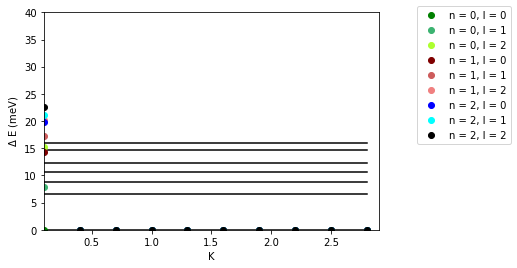

In [32]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

K = np.linspace(0.1,2.8,10) 

gr = [-16.04+16.04]*len(K)
ex1 = [-9.53+16.04]*len(K)
ex2 = [-7.21+16.04]*len(K)
ex3 = [-5.4+16.04]*len(K)
ex4 = [-3.74+16.04]*len(K)
ex5 = [-1.39+16.04]*len(K)
ex6 = [0+16.04]*len(K)

fig = plt.figure()
ax = plt.subplot(111)

data = [gr, ex1, ex2, ex3, ex4, ex5, ex6]
for i in range(len(data)):
    plt.plot(K, data[i], color = 'k')

lbel = ['n = 0, l = 0', 'n = 0, l = 1', 'n = 0, l = 2', 'n = 1, l = 0', 'n = 1, l = 1', 'n = 1, l = 2', 'n = 2, l = 0', 'n = 2, l = 1', 'n = 2, l = 2']
clor = ['green', 'mediumseagreen', 'greenyellow', 'maroon', 'indianred', 'lightcoral', 'blue', 'aqua', 'k']

for i in range(9):
    ax.plot(K, Edelta_order[i], 'o', label = lbel[i], color = clor[i])
plt.xlim(0.1, 2.9)
plt.ylim(0, 40)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("$\Delta$ E (meV)")
plt.xlabel('K')
plt.savefig('PulsGa_K1.23_to_1.33wLegendMattStyle.png')
plt.show()

In [34]:
import plotly.graph_objects as go
import numpy as np

E_inCm = [0, 3.7, 5.1, 2, 4.5, 5.5, 3.9, 5.2, 5.8]
E_in_meV = np.array(E_inCm)*10/2.6
E_an = [round(x, 5) for x in E_in_meV]

MattE = [0.6, 1.35, 2.4, 3.3, 4.3, 5.25, 6.25]
MattE = np.array(MattE)*10/3
Matt_data = [round(x, 5) for x in MattE]

E2 = [0]*9
E2[0] = Edelta_order[0][0]
E2[1] = Edelta_order[1][0]
E2[2] = Edelta_order[2][0]
E2[3] = Edelta_order[3][0]
E2[4] = Edelta_order[4][0]
E2[5] = Edelta_order[5][0]
E2[6] = Edelta_order[6][0]
E2[7] = Edelta_order[7][0]
E2[8] = Edelta_order[8][0]

Delta = [0]*9
Delta[0] = E2[0] - E_an[0]
Delta[1] = E2[1] - E_an[3]
Delta[2] = E2[2] - E_an[6]
Delta[3] = E2[3] - E_an[1]
Delta[4] = E2[4] - E_an[4]
Delta[5] = E2[5] - E_an[7]
Delta[6] = E2[6] - E_an[2]
Delta[7] = E2[7] - E_an[5]
Delta[8] = E2[8] - E_an[8]

Delta1 = [round(x, 5) for x in Delta]

E2 = [round(x, 5) for x in E2]

gr = -16.04+16.04
ignore1 = 1.53
ignore2 = 4.64
ex1 = -9.53+16.04
ex2 = -7.21+16.04
ex3 = -5.4+16.04
ex4 = -3.74+16.04
ex5 = -1.39+16.04
ex6 = 0+16.04


data = [gr, ex1, ex2, ex3, ex4, ex5, ex6]
data = [round(x, 5) for x in data]

fig = go.Figure(data=[go.Table(header=dict(values=['1st quantum number n', '2nd quantum number l', 'Matt Graph Calc EigenEnergy K = 1.24','Our Calc EigenEnergy K = 1.24', 'Delta b/w Matt Graph and Our Calc', 'Matt Graph Experimental Energy','Dr Watkins Experimental for Ga']),
                 cells=dict(values=[['0', '', '', '1', '', '', '2', '', '', ],
                                    ['0', '1' ,'2' , '0','1' ,'2' , '0','1' ,'2'],
                                    [E_an[0], E_an[3], E_an[6], E_an[1], E_an[4], E_an[7], E_an[2], E_an[5], E_an[8]],
                                    [E2[0], E2[1], E2[2], E2[3], E2[4], E2[5], E2[6], E2[7], E2[8]],
                                    [Delta1[0], Delta1[1], Delta1[2], Delta1[3], Delta1[4], Delta1[5], Delta1[6], Delta1[7], Delta1[8]],
                                    [Matt_data[0], Matt_data[1], Matt_data[2], Matt_data[3], Matt_data[4], Matt_data[5], Matt_data[6]],
                                    [data[0], data[1], data[2], data[3], data[4], data[5], data[6]]]
                                    ))])
fig.show()

In [11]:
import plotly.graph_objects as go
import numpy as np

En1 = [x*0.111*1000 for x in En] # in meV now

fig = go.Figure(data=[go.Table(header=dict(values=['1st quantum number n', '2nd quantum number l', 'EigenEnergy']),
                 cells=dict(values=[['0', '', '', '1', '', '', '2', '', '', ],
                                    ['0', '1' ,'2' , '0','1' ,'2' , '0','1' ,'2'],
                                    [En1[0], En1[3], En1[6], En1[1], En1[4], En1[7], En1[2], En1[5], En1[8]]]
                                    ))])
fig.show()

NameError: name 'En' is not defined

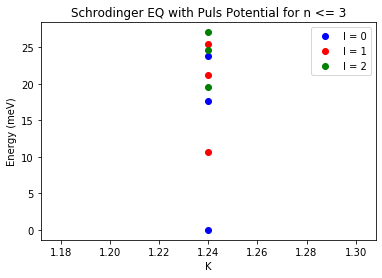

In [3]:
a = list(range(15))
n = [x+1 for x in a]

En2 = [x - En1[0] for x in En1]
K = [1.24]*3

plt.plot(K, En2[0:3], 'o', label = 'l = 0', color = 'b')
plt.plot(K, En2[3:6], 'o', label = 'l = 1', color = 'r')
plt.plot(K, En2[6:9], 'o', label = 'l = 2', color = 'g')
#plt.plot(n[0:5], [0]*5, label = 'zero')
plt.xlabel("K")
plt.ylabel('Energy (meV)')
plt.title('Schrodinger EQ with Puls Potential for n <= 3')
plt.legend()
plt.show()

In [5]:
import plotly.graph_objects as go
import numpy as np

En2 = [round(x, 5) for x in En2]

E_inCm = [0, 3.7, 5.1, 2, 4.5, 5.5, 3.9, 5.2, 5.8]
E_in_meV = np.array(E_inCm)*10/2.6
E_an = [round(x, 5) for x in E_in_meV]

fig = go.Figure(data=[go.Table(header=dict(values=['1st quantum number n', '2nd quantum number l', 'Delta EigenEnergy', 'Matt Graph Delta EigenEnergy']),
                 cells=dict(values=[['0', '', '', '1', '', '', '2', '', '', ],
                                    ['0', '1' ,'2' , '0','1' ,'2' , '0','1' ,'2'],
                                    [En2[0], En2[3], En2[6], En2[1], En2[4], En2[7], En2[2], En2[5], En2[8]], 
                                    [E_an[0], E_an[3], E_an[6], E_an[1], E_an[4], E_an[7], E_an[2], E_an[5], E_an[8]]]
                                    ))])
fig.show()

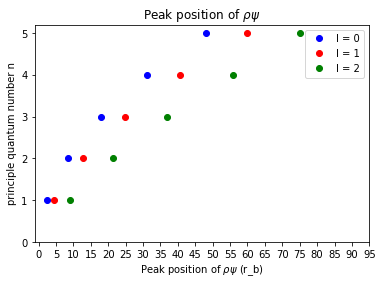

In [108]:
fMax_index = [0]*15
for i in range(15):
    fMax = max(f_nl[i][:])
    fMax_index[i] = f_nl[i][:].index(fMax)
fMax_index = [x/2000*100 for x in fMax_index]  

plt.plot(fMax_index[0:5], n[0:5], 'o', label = 'l = 0', color = 'b')
plt.plot(fMax_index[5:10], n[0:5], 'o', label = 'l = 1', color = 'r')
plt.plot(fMax_index[10:15], n[0:5], 'o', label = 'l = 2', color = 'g')
plt.ylabel("principle quantum number n")
plt.xlabel('Peak position of $\\rho\psi$ (r_b)')
plt.title('Peak position of $\\rho\psi$')
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 5.5, 1))
plt.legend()
plt.show()

****** The minimum of the Puls Potential is (in r_b)  1.35


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

divide by zero encountered in true_divide

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

divide by zero encountered in true_divide



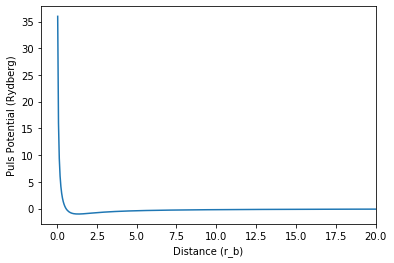

In [109]:
plt.plot(rho, PulsV(rho))
plt.xlim(-1, 20)
plt.ylabel("Puls Potential (Rydberg)")
plt.xlabel('Distance (r_b)')
Puls_list = PulsV(rho).tolist()
Puls_min = min(Puls_list[1::])
print('****** The minimum of the Puls Potential is (in r_b) ', Puls_list.index(Puls_min)/2000*100)

In [154]:
import pandas as pd

name_dict = En

df = pd.DataFrame(name_dict)
df.style.hide_index()
print(df)
df.to_csv('PulsPotential2', index = False)
print(df.to_csv(sep='\t', index=False))

           0
0  -0.460993
1  -0.165648
2  -0.083839
3  -0.050439
4  -0.033636
5  -0.230614
6  -0.104768
7  -0.059718
8  -0.038544
9  -0.026869
10 -0.110765
11 -0.062293
12 -0.039875
13 -0.027673
14 -0.019436
0
-0.46099311852456204
-0.1656481630077466
-0.08383909765292245
-0.0504393505067928
-0.0336362456760509
-0.23061423816905469
-0.10476764646283081
-0.05971764525525558
-0.03854354452019469
-0.026868644959027913
-0.11076489021249594
-0.06229301510898179
-0.039875499037330626
-0.02767335731978158
-0.01943566389942875

